<a href="https://colab.research.google.com/github/aditya8975/2thespace/blob/main/Copy_of_BrainT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Define the path to your dataset zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Brain Tumor MRI.zip'

# Extract the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/BrainTumorData')

# Check if the extraction worked
os.listdir('/content/BrainTumorData')


Mounted at /content/drive


['Testing', 'Training']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

train_dir = '/content/BrainTumorData/Training'
test_dir = '/content/BrainTumorData/Testing'

BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

# Load training and testing datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Check the class names
class_names = train_ds.class_names
print(class_names)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


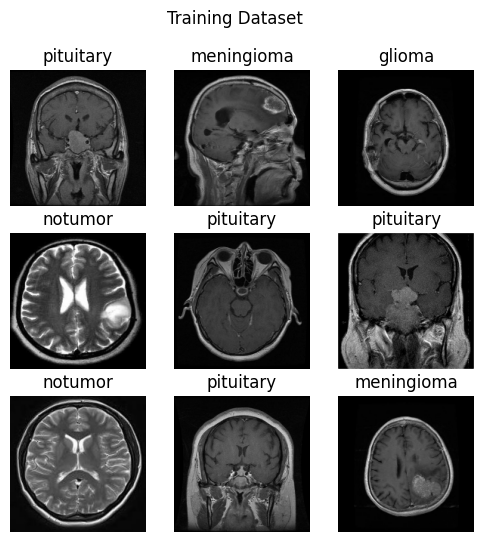

In [ ]:
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_ds, "Training Dataset")


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.4958 - loss: 1.1010 - val_accuracy: 0.7353 - val_loss: 0.7429
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.7557 - loss: 0.6144 - val_accuracy: 0.7849 - val_loss: 0.5902
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.8170 - loss: 0.4610 - val_accuracy: 0.7567 - val_loss: 0.6109
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.8512 - loss: 0.3898 - val_accuracy: 0.8261 - val_loss: 0.4492
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.8647 - loss: 0.3371 - val_accuracy: 0.8665 - val_loss: 0.3425
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.8887 - loss: 0.2769 - val_accuracy: 0.8696 - val_loss: 0.3324
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.9131 - loss: 0.2341 - val_accuracy: 0.8993 - val_loss: 0.2563
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9207 - loss: 0.2053 - val_accu

In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f'Test Accuracy: {accuracy:.2f}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 755ms/step - accuracy: 0.9295 - loss: 0.1953
Test Accuracy: 0.93


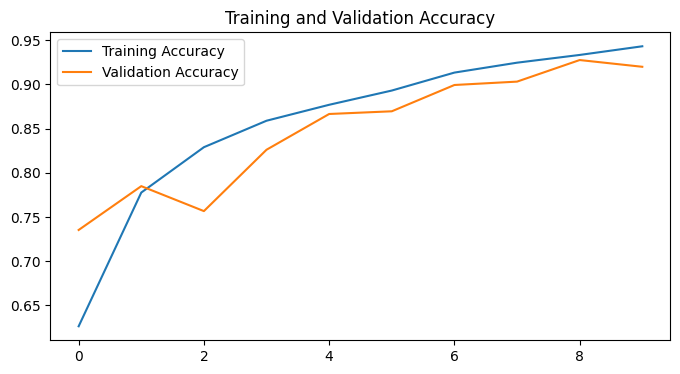

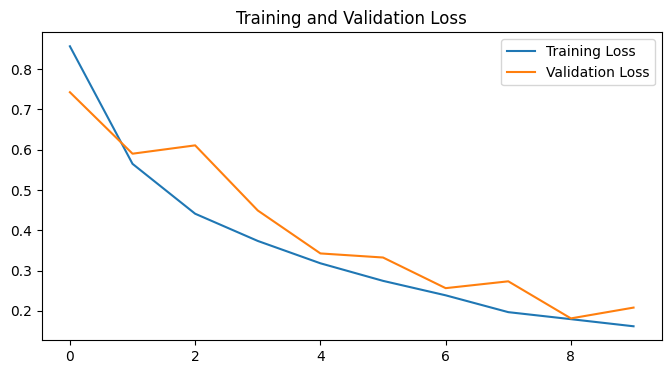

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/brain_tumor_model.h5')


In [ ]:
from tensorflow.keras.preprocessing import image

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/brain_tumor_model.h5')

# Load and preprocess the image
img_path = '/content/BrainTumorData/Testing/glioma/Te-glTr_0001.jpg'

plt.show()
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Predict
predictions = loaded_model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted class: glioma
